<a href="https://colab.research.google.com/github/keller-kirill/dl_practice/blob/main/de_gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting gender of german nouns using LSTM many-to-one mode

## Problem
Every german word could be of one of three genders – masculine, feminine and neutral. Gender of the noun in german determines the article which one should use. Moreover, articles are changing depending on the case (Nominative, Akkusative, Dativ and Genitiv). 

Native german speaking people know noun's gender intuitively. German learner has to learn them all, but there exist several patterns on which one can rely – for example by the words ending (-ung or -e mean always feminine, -er is often masculine). 

LSTMs are special type of RNNs which show themselve quite well in many NLP problems. This work is aimed on checking whether it's possible to train the LSTM network simply on letter sequences to predict the word's gender. 

## Tasks

* First, the data need to be found. Ideally, we need large dictionary of german nouns with articles or class.
* Then, we'll try to perform simple EDA to learn some statistics about german words.
* We will set the problem as a multi-label classification. 
* We will build LSTM many-to-one model and train it on our dataset.
* Lastly, the obtained results will be compared with alternative approaches. 



# Data
In this project we used dictionary of german nouns from @gambolputty https://github.com/gambolputty/german_nouns/tree/master/german_nouns

In [1]:
import pandas as pd
import numpy as np

In [2]:
DATASET = 'https://raw.githubusercontent.com/keller-kirill/german_nouns/master/german_nouns/nouns.csv'

In [3]:
df = pd.read_csv(DATASET, dtype='object')

In [4]:
df.sample(10)

,lemma,pos,genus,genus 1,genus 2,genus 3,genus 4,nominativ singular,nominativ singular*,nominativ singular 1,nominativ singular 2,nominativ singular 3,nominativ singular 4,nominativ singular stark,nominativ singular schwach,nominativ singular gemischt,nominativ plural,nominativ plural*,nominativ plural 1,nominativ plural 2,nominativ plural 3,nominativ plural 4,nominativ plural stark,nominativ plural schwach,nominativ plural gemischt,genitiv singular,genitiv singular*,genitiv singular 1,genitiv singular 2,genitiv singular 3,genitiv singular 4,genitiv singular stark,genitiv singular schwach,genitiv singular gemischt,genitiv plural,genitiv plural*,genitiv plural 1,genitiv plural 2,genitiv plural 3,genitiv plural 4,genitiv plural stark,genitiv plural schwach,genitiv plural gemischt,dativ singular,dativ singular*,dativ singular 1,dativ singular 2,dativ singular 3,dativ singular 4,dativ singular stark,dativ singular schwach,dativ singular gemischt,dativ plural,dativ plural*,dativ plural 1,dativ plural 2,dativ plural 3,dativ plural 4,dativ plural stark,dativ plural schwach,dativ plural gemischt,akkusativ singular,akkusativ singular*,akkusativ singular 1,akkusativ singular 2,akkusativ singular 3,akkusativ singular 4,akkusativ singular stark,akkusativ singular schwach,akkusativ singular gemischt,akkusativ plural,akkusativ plural*,akkusativ plural 1,akkusativ plural 2,akkusativ plural 3,akkusativ plural 4,akkusativ plural stark,akkusativ plural schwach,akkusativ plural gemischt
14434,Christkindl,"Substantiv,Toponym",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44182,Laab im Walde,"Substantiv,Toponym",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Laabs im Walde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15611,Deadlock,Substantiv,m,NaN,NaN,NaN,NaN,Deadlock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deadlocks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deadlocks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deadlocks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deadlock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deadlocks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deadlock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deadlocks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31501,Halteproblem,Substantiv,n,NaN,NaN,NaN,NaN,Halteproblem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Halteprobleme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Halteproblems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Halteprobleme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Halteproblem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Halteproblemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Halteproblem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Halteprobleme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76063,Talent,Substantiv,n,NaN,NaN,NaN,NaN,Talent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Talente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Talentes,Talents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Talente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Talent,Talente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Talenten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Talent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Talente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30415,Grundschülerin,Substantiv,f,NaN,NaN,NaN,NaN,Grundschülerin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grundschülerinnen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grundschülerin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grundschülerinnen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grundschülerin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grundschülerinnen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grundschülerin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grundschülerinnen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47120,Lychen,"Substantiv,Toponym",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90212 entries, 0 to 90211
Data columns (total 79 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   lemma                        90212 non-null  object
 1   pos                          90212 non-null  object
 2   genus                        80566 non-null  object
 3   genus 1                      1173 non-null   object
 4   genus 2                      1186 non-null   object
 5   genus 3                      39 non-null     object
 6   genus 4                      1 non-null      object
 7   nominativ singular           78706 non-null  object
 8   nominativ singular*          4 non-null      object
 9   nominativ singular 1         1175 non-null   object
 10  nominativ singular 2         1188 non-null   object
 11  nominativ singular 3         39 non-null     object
 12  nominativ singular 4         1 non-null      object
 13  nominativ singular stark     17

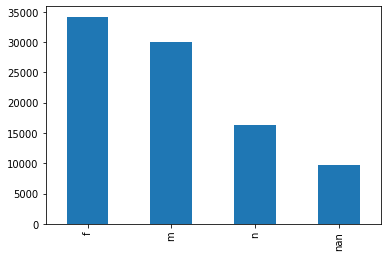

In [6]:
df.genus.value_counts(dropna=False).plot.bar()

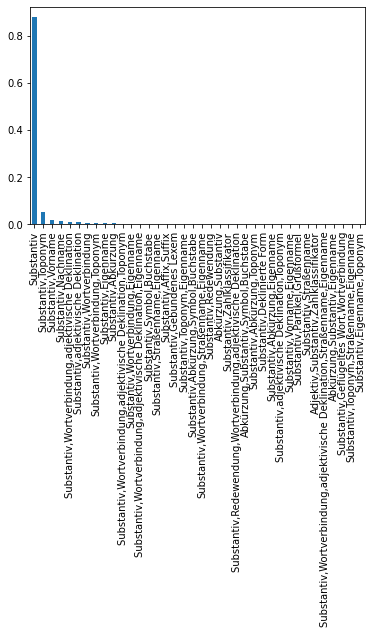

In [7]:
df.pos.value_counts(dropna=False, normalize=True).plot.bar()

We can see that the dataset mostly consists of 'Substantiv' pos classes. I suspect that most nans are related to those <5% entries

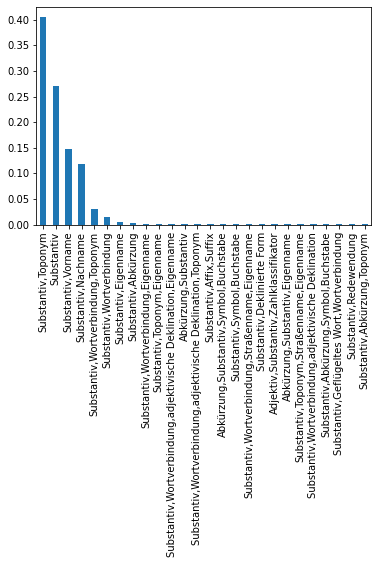

In [8]:
df[df.genus.isna()].pos.value_counts(dropna=False, normalize=True).plot.bar()

Let's drop toponyms, names, abbreviations, etc – they usually don't have any gender, therefore are out of scope of this work

In [9]:
(df.pos == 'Substantiv').value_counts(normalize=True)

True     0.879284
False    0.120716
Name: pos, dtype: float64

In [10]:
df = df[df.pos == 'Substantiv']

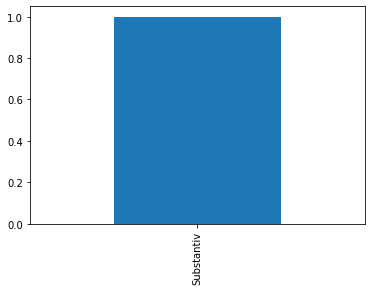

In [11]:
df.pos.value_counts(dropna=False, normalize=True).plot.bar()

In [12]:
df.sample(10)

,lemma,pos,genus,genus 1,genus 2,genus 3,genus 4,nominativ singular,nominativ singular*,nominativ singular 1,nominativ singular 2,nominativ singular 3,nominativ singular 4,nominativ singular stark,nominativ singular schwach,nominativ singular gemischt,nominativ plural,nominativ plural*,nominativ plural 1,nominativ plural 2,nominativ plural 3,nominativ plural 4,nominativ plural stark,nominativ plural schwach,nominativ plural gemischt,genitiv singular,genitiv singular*,genitiv singular 1,genitiv singular 2,genitiv singular 3,genitiv singular 4,genitiv singular stark,genitiv singular schwach,genitiv singular gemischt,genitiv plural,genitiv plural*,genitiv plural 1,genitiv plural 2,genitiv plural 3,genitiv plural 4,genitiv plural stark,genitiv plural schwach,genitiv plural gemischt,dativ singular,dativ singular*,dativ singular 1,dativ singular 2,dativ singular 3,dativ singular 4,dativ singular stark,dativ singular schwach,dativ singular gemischt,dativ plural,dativ plural*,dativ plural 1,dativ plural 2,dativ plural 3,dativ plural 4,dativ plural stark,dativ plural schwach,dativ plural gemischt,akkusativ singular,akkusativ singular*,akkusativ singular 1,akkusativ singular 2,akkusativ singular 3,akkusativ singular 4,akkusativ singular stark,akkusativ singular schwach,akkusativ singular gemischt,akkusativ plural,akkusativ plural*,akkusativ plural 1,akkusativ plural 2,akkusativ plural 3,akkusativ plural 4,akkusativ plural stark,akkusativ plural schwach,akkusativ plural gemischt
57515,Pendlerzug,Substantiv,m,NaN,NaN,NaN,NaN,Pendlerzug,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pendlerzüge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pendlerzuges,Pendlerzugs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pendlerzüge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pendlerzug,Pendlerzuge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pendlerzügen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pendlerzug,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pendlerzüge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85044,Wermut,Substantiv,m,NaN,NaN,NaN,NaN,Wermut,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wermuts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wermuts,Wermutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wermuts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wermut,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wermuts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wermut,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wermuts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13088,Bundesversammlung,Substantiv,f,NaN,NaN,NaN,NaN,Bundesversammlung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bundesversammlungen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bundesversammlung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bundesversammlungen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bundesversammlung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bundesversammlungen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bundesversammlung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bundesversammlungen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88067,Zitierung,Substantiv,f,NaN,NaN,NaN,NaN,Zitierung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zitierungen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zitierung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zitierungen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zitierung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zitierungen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zitierung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zitierungen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77349,Thorn,Substantiv,n,NaN,NaN,NaN,NaN,Thorn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thorns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thorns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thorns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thorn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thorns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thorn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thorns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5766,Atrazin,Substantiv,n,NaN,NaN,NaN,NaN,Atrazin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atrazine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atrazins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atrazine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atrazin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atrazinen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atrazin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atrazine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24445,Flügelaltar,Substantiv,m,NaN,NaN,NaN,NaN,Flügelaltar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Flügelaltäre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Flügelaltares,Flügelaltars

Now we need to drop all rows without gender

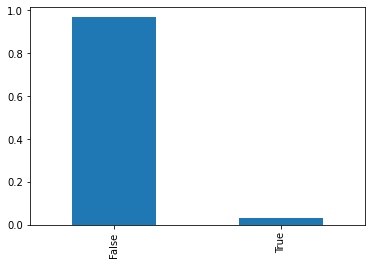

In [13]:
df.genus.isna().value_counts(normalize=True).plot.bar()

In [14]:
df = df[df['genus'].notna()]

In [15]:
df.shape

(76716, 79)

We are interested only in 2 columns – lemma and genus. Let's drop all the others

In [16]:
df = df[['lemma', 'genus']]
df['lemma'] = df['lemma'].str.lower()

In [17]:
df.sample(10)

,lemma,genus
88889,zylinderblock,m
33484,hinduismus,m
21359,euler,m
79467,türkette,f
72368,sprachbarriere,f
44197,labialisierung,f
84043,wasserturbine,f
35995,ingrimm,m
44212,laborleiter,m
46059,liebesleben,n


## Predicting word's gender based on most common endings

According to [Wikipedia](https://en.wikipedia.org/wiki/Grammatical_gender_in_German) for some words it is easy to know grammatical gender based on ending of the word. Maybe we can avoid using neural networks? 

Let's see what is the accuracty of totally random classifier:

In [18]:
np.random.seed(23)
rand_preds = np.random.choice(['f', 'n', 'm'], len(df))
(df['genus'] == rand_preds).sum() / len(df) 

0.3327467542624746

In [19]:
endings = {'m':['ant', 'ast', 'ich', 'ig', 'ismus', 'ling', 'or', 'us'],
           'f':['a', 'anz', 'ei', 'enz', 'heit', 'ie', 'ik', 'in', 'keit', 
             'schaft', 'sion', 'tät', 'tion', 'ung', 'ur'],
           'n':['chen', 'lein', 'ma', 'ment', 'sel', 'tel', 'tum', 'um']}

In [20]:
def ending_gender_clf(word):
    for gender, ends in endings.items():
        for end in ends:
            if word.endswith(end):
                return gender
    return '-'

In [21]:
ending_preds = df['lemma'].apply(ending_gender_clf)
ending_preds.value_counts(normalize=True)

-    0.692255
f    0.236391
n    0.036642
m    0.034712
Name: lemma, dtype: float64

In [22]:
(df[ending_preds != '-']['genus'] == ending_preds[ending_preds != '-']).sum() / len(ending_preds[ending_preds != '-'])

0.8715320428650091

In [23]:
(df['genus'] == ending_preds).sum() / len(df) 

0.26821002137754835

* Less than 30 % of words have common endings
* For those 30 % we achieved 0.87 accuracy with naive endings classifier – not bad!
* But total accuracy is only 26 % – even worse than random classifier!

In previous experiment we used only "strong" endings, i.e. endings for which very few counter-examples exist.

Let's extend the list by including not so confident endings. The function 'ending_gender_clf' has a problem of assigning class based on first encountered ending. Howewer, in some cases there could be colisions, e.g. in case of weak (not 100 %) ending 't' and strong 'ant' – we should give priority to longer endings. Let's make a new dictionary, instead of 'gender':'endings list', we will use 'ending':'gender' pairs. 

In [24]:
# First let's simply extend the existing dict
endings = {'m':['ant', 'ast', 'ich', 'ig', 'ismus', 'ling', 'or', 'us', 'el', 
                'er', 'en'],
           'f':['a', 'anz', 'ei', 'enz', 'heit', 'ie', 'ik', 'in', 'keit', 
                'schaft', 'sion', 'tät', 'tion', 'ung', 'ur', 'e', 't'],
           'n':['chen', 'lein', 'ma', 'ment', 'sel', 'tel', 'tum', 'um', 'nis',
                'sal', 'al', 'an', 'ar', 'är', 'at', 'ent', 'ett', 'ier', 'iv',
                'o', 'on']}

end2gen = {end:gender for (gender, ends) in endings.items() for end in ends}

In [25]:
def endings_gender_clf(word):
    for end in sorted(end2gen, key=len, reverse=True): # longest first
        if word.endswith(end):
                return end2gen[end]
    return '-'

In [26]:
ending_preds = df['lemma'].apply(endings_gender_clf)
ending_preds.value_counts(normalize=True)

f    0.483028
-    0.231699
m    0.187718
n    0.097555
Name: lemma, dtype: float64

In [27]:
(df[ending_preds != '-']['genus'] == ending_preds[ending_preds != '-']).sum() / len(ending_preds[ending_preds != '-'])

0.7491389694779526

In [28]:
(df['genus'] == ending_preds).sum() / len(df) 

0.5755644194170707

* Including "weak" ending allowed us to increase classified fraction of dictionary to 77 % (compared to previous 30 %)
* For those 77 % words we achieved 74.9 % accuracy;
* But total accuracy is already 57.5 % which is more than twice larger compared to previous results and better than random.

Let's also predict random gender for words without an ending

In [29]:
def gender_clf(word):
    for end in sorted(end2gen, key=len, reverse=True):
        if word.endswith(end):
                return end2gen[end]
    return np.random.choice(['f', 'n', 'm'], 1)[0]

In [30]:
ending_preds = df['lemma'].apply(gender_clf)
ending_preds.value_counts(normalize=True)

f    0.559961
m    0.265877
n    0.174162
Name: lemma, dtype: float64

In [31]:
(df['genus'] == ending_preds).sum() / len(df) 

0.6544136816309505

The total accuracy of our rule-based + random classifier gives quite good performance. We can try to increase the accuracy more by implementing several more heuristics, but let's stop on this for now and use this simple "model" as a baseline. We will try to beat it with RNN LSTM model.

# LSTM

In [32]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.cuda import LongTensor

device = torch.device("cuda:0") # Let's make sure GPU is available!

## Dataset preparation

Let's create a torch Dataset sublclass for our dataset to easier data handling. Each word in the dictionary will be represented as a vector of indices from the "alphabet".

In [34]:
class GermanNouns(Dataset):
    def __init__(self, df):
        """
        Parameters:
        df – pandas 2-column dataframe: 1st col – words, 2nd col – gender (target)
        """
        self.data = df.to_numpy()

        self.letters = {letter for word in self.data[:, 0] for letter in word}
        self.letter2ind = {letter: ind + 1 for ind, letter in enumerate(self.letters)}
        self.letter2ind['<pad>'] = 0 # LSTM accept only inputs of the same len
        self.ind2letter = {ind: letter for letter, ind in self.letter2ind.items()}


        self.genders = {gender for gender in self.data[:, 1]} # target
        self.gender2ind = {gender: ind for ind, gender in enumerate(self.genders)}

        self.nouns = [[self.letter2ind.get(letter, 0) for letter in sample] 
                      for sample in self.data[:, 0]] # vector of indices
        self.labels = [self.gender2ind[gender] for gender in self.data[:, 1]]

    def __len__(self):
        """
        return the number of word-vectors in the dataset
        """
        return len(self.nouns)

    def __getitem__(self, index):
        """
        Returns a word-vector (vector of indices), class label (['f', 'n', 'm']),
        and len of the word-vector (required for dataloader)
        """
        word = self.nouns[index]
        label = self.labels[index]
        return torch.Tensor(word).long().cuda(), label, len(word)

    def nums2word(self, numbers):
        """
        Transforms a list of vocabulary numbers into initial word 
        """
        return ''.join(
            [self.ind2letter[n] for n in numbers.tolist()]).replace('<pad>', '')

dataset = GermanNouns(df)
dataset[44622][0], dataset.nums2word(dataset[44622][0])

(tensor([30, 27,  3, 20, 43, 57, 59, 48, 57], device='cuda:0'), 'nachteule')

In [ ]:
data_size = len(dataset)
train_fraction = 0.8
test_fraction = 0.15
batch_size=64

train_split = int(np.floor((train_fraction) * data_size))
test_split = int(np.floor(test_fraction * train_split))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

train_indices, test_indices, val_indices = (indices[test_split:train_split], 
                                            indices[:test_split],
                                            indices[train_split:])

assert len(train_indices) + len(test_indices) + len(val_indices) == len(dataset)

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [35]:
def my_collate(batch):
    """
    This function is called by DataLoader to pad every input tensor 
    in the batch to the same len
        batch: is a list of (tokens, label, length) tuples
            where 'tokens' is a list of arbitrary len
            and label/length are scalars
    """
    tokens, labels, lengths = zip(*batch)
    x = pad_sequence(tokens)
    return x, labels


train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, 
                                           collate_fn=my_collate)

val_loader = DataLoader(dataset, batch_size=batch_size*8,
                                         sampler=val_sampler,
                                         collate_fn=my_collate)

test_loader = DataLoader(dataset, batch_size=batch_size, 
                                          sampler=test_sampler,
                                          collate_fn=my_collate)

In [37]:
X_batch, y_batch = next(iter(train_loader)) # Test of dataloader

dataset.nums2word(X_batch[:, 0])

'ostberlinerin'

In [40]:
class LSTMGender(nn.Module):
    """
    LSTM RNN for prediction of grammatical gender based on the word itself
    """
    def __init__(self, vocab_size, target_size, letter_emb_dim=64, lstm_hidden_dim=128, lstm_layers_count=1):
        """
        Parameters:
            vocab_size – size of the vocabulary (alphabet) for embedding layer
            target_size – number of classes (3)
            letter_emb_dim – output size of the word embeddings
            lstm_hidden_dim, lstm_layers_count – parameters of LSTM layer
        """
        super().__init__()
        self.letter_embedding = nn.Embedding(vocab_size, letter_emb_dim)
        self.lstm = nn.LSTM(input_size=letter_emb_dim, hidden_size=lstm_hidden_dim, 
                            num_layers=lstm_layers_count)
        self.hidden2gender = nn.Linear(lstm_hidden_dim, target_size)

    def forward(self, inputs):
        embeds = self.letter_embedding(inputs)
        output, _ = self.lstm(embeds)
        gender_space = self.hidden2gender(output[-1, :, :])
        return gender_space

In [59]:
import time

def train_model(model, train_loader, val_loader, loss,
                optimizer, num_epochs, scheduler=None):
    """
    Training the model

    Returns change of train loss, train and val accuracy on every epoch
    """
    since = time.time()    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (X_batch, y_batch) in enumerate(train_loader):
          
            X_batch = LongTensor(X_batch).to(device)
            y_batch = LongTensor(y_batch).to(device)
            prediction = model(X_batch)    
            loss_value = loss(prediction, y_batch)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_batch)
            total_samples += y_batch.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy, _, _ = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        if scheduler:
            scheduler.step()

        print("#%d:Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (
            epoch, ave_loss, train_accuracy, val_accuracy))
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                            time_elapsed % 60))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct = 0
    total = 0
    preds = []
    trues = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i_step, (X_batch, y_batch) in enumerate(loader):
            X_batch = LongTensor(X_batch).to(device)
            y_batch = LongTensor(y_batch).to(device)
            # calculate outputs by running images through the network 
            outputs = model(X_batch)
            # the class with the highest energy is what we choose as prediction
            predicted = torch.argmax(outputs.data, 1)
            preds.append(predicted)
            trues.append(y_batch)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    return accuracy, preds, trues

In [42]:
model = LSTMGender(
    vocab_size=len(dataset.letter2ind),
    target_size=len(dataset.gender2ind),
    lstm_layers_count=1, 
    lstm_hidden_dim=80
).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=1E-5, lr=1E-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                  step_size=9, gamma=0.85)


loss_history, train_history, val_history = train_model(model, train_loader, val_loader, criterion, optimizer, 50, scheduler=scheduler)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


#0:Average loss: 0.584578, Train accuracy: 0.759426, Val accuracy: 0.816280
#1:Average loss: 0.421217, Train accuracy: 0.843004, Val accuracy: 0.848931
#2:Average loss: 0.373482, Train accuracy: 0.864435, Val accuracy: 0.860467
#3:Average loss: 0.351589, Train accuracy: 0.873637, Val accuracy: 0.864051
#4:Average loss: 0.333846, Train accuracy: 0.880365, Val accuracy: 0.870438
#5:Average loss: 0.319232, Train accuracy: 0.887170, Val accuracy: 0.879758
#6:Average loss: 0.312688, Train accuracy: 0.889815, Val accuracy: 0.877086
#7:Average loss: 0.304484, Train accuracy: 0.892806, Val accuracy: 0.883929
#8:Average loss: 0.306410, Train accuracy: 0.891157, Val accuracy: 0.875196
#9:Average loss: 0.286617, Train accuracy: 0.899266, Val accuracy: 0.890120
#10:Average loss: 0.277477, Train accuracy: 0.902946, Val accuracy: 0.894747
#11:Average loss: 0.268975, Train accuracy: 0.906454, Val accuracy: 0.892531
#12:Average loss: 0.263788, Train accuracy: 0.906934, Val accuracy: 0.887578
#13:Avera

In [43]:
test_acc, preds, trues = compute_accuracy(model, test_loader)
test_acc

0.9219989136338946

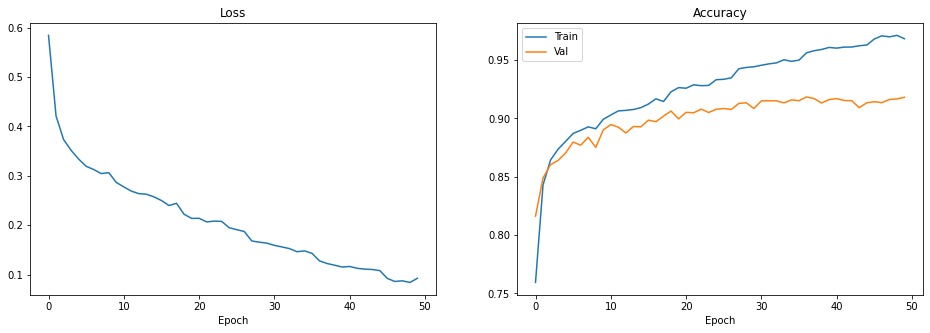

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(loss_history, label='Train')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')

ax[1].plot(train_history, label='Train')
ax[1].plot(val_history, label='Val')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend()

## Analysis of mistakes
Let's create a new dataloader for ALL dataset and predict a gender. Then, we will use sklearn to calculate and plot confuison matrix


In [70]:
total_loader = DataLoader(dataset, batch_size=1024,collate_fn=my_collate)
total_acc, all_preds, all_trues = compute_accuracy(model, total_loader)
total_acc

0.9600865530006778

In [73]:
all_preds = torch.cat(all_preds).cpu()
all_trues = torch.cat(all_trues).cpu()

In [74]:
from sklearn.metrics import confusion_matrix

In [78]:
conf_matrix = confusion_matrix(all_trues, all_preds)

Normalized confusion matrix
[[0.92687292 0.05433393 0.01879315]
 [0.01959751 0.96210445 0.01829804]
 [0.00822111 0.01751587 0.97426301]]


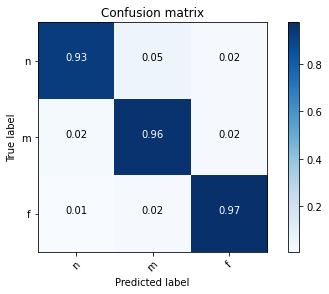

In [82]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(conf_matrix, list(dataset.genders), normalize=True)

# Conclusions
* Least accurate class – neutral
* Might be because it's less represented in the dataset
* Most often confusion is predicting masculine instead of neutral. Least common – feminine predicted as neutral.
* In general for such a simple model LSTM achieves amazing performance – 92 % correctly assigned grammatical gender. Model learned the hidden pattern purely from letter sequences. 
* LSTM outperforms the naive ending-random model – super!